<a href="https://colab.research.google.com/github/VennelaRLankala/Colorectal-BRAF-ctDNA-Analysis/blob/main/ctDNA_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: install system tools and python packages (run once)
import subprocess, sys

install_cmds = [
    "apt-get update -qq",
    # install compiled tools (fastp via apt)
    "DEBIAN_FRONTEND=noninteractive apt-get install -y -qq wget unzip samtools bwa bedtools bcftools tabix fastqc fastp freebayes default-jre",
    # python libs
    "pip install -q pysam cyvcf2 pandas matplotlib pysradb"
]

for cmd in install_cmds:
    print("RUN:", cmd)
    subprocess.run(cmd, shell=True, check=True)
print("Installation complete.")


RUN: apt-get update -qq
RUN: DEBIAN_FRONTEND=noninteractive apt-get install -y -qq wget unzip samtools bwa bedtools bcftools tabix fastqc fastp freebayes default-jre
RUN: pip install -q pysam cyvcf2 pandas matplotlib pysradb
Installation complete.


In [ ]:
# Cell 2: set variables - edit these before running later cells
import os
PROJECT = "/content/ctDNA_project"   # working folder in Colab
SRR_BASE = "SRR13974039"            # baseline SRR
SRR_POST = "SRR13974040"            # post-treatment SRR
GENE = "BRAF"                       # gene to analyze; change as needed
THREADS = "2"                       # number of threads for bwa/fastp, etc.

# export into environment for later Python cells that call subprocess
os.environ["PROJECT"] = PROJECT
os.environ["SRR_BASE"] = SRR_BASE
os.environ["SRR_POST"] = SRR_POST
os.environ["GENE"] = GENE
os.environ["THREADS"] = THREADS

# create directories
dirs = ["fastq", "reference", "bam", "qc", "results", "logs"]
for d in dirs:
    path = os.path.join(PROJECT, d)
    os.makedirs(path, exist_ok=True)

print("Project:", PROJECT)
print("Baseline SRR:", SRR_BASE)
print("Post SRR:", SRR_POST)
print("Gene:", GENE)
print("Threads:", THREADS)


Project: /content/ctDNA_project
Baseline SRR: SRR13974039
Post SRR: SRR13974040
Gene: BRAF
Threads: 2


In [ ]:
# Cell 4: download FASTQ files from ENA (fast and reliable) and unzip
import os, subprocess
PROJECT = os.environ["PROJECT"]
SRR_BASE = os.environ["SRR_BASE"]
SRR_POST = os.environ["SRR_POST"]

os.chdir(os.path.join(PROJECT, "fastq"))
links = [
    f"ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/039/{SRR_BASE}/{SRR_BASE}_1.fastq.gz",
    f"ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/039/{SRR_BASE}/{SRR_BASE}_2.fastq.gz",
    f"ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/040/{SRR_POST}/{SRR_POST}_1.fastq.gz",
    f"ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/040/{SRR_POST}/{SRR_POST}_2.fastq.gz"
]

for url in links:
    print("Downloading:", url)
    subprocess.run(f"wget -c {url}", shell=True, check=True)

# unzip and standardize names
subprocess.run("gunzip -f *.fastq.gz", shell=True, check=True)
subprocess.run(f"mv {SRR_BASE}_1.fastq baseline_R1.fastq", shell=True, check=True)
subprocess.run(f"mv {SRR_BASE}_2.fastq baseline_R2.fastq", shell=True, check=True)
subprocess.run(f"mv {SRR_POST}_1.fastq post_R1.fastq", shell=True, check=True)
subprocess.run(f"mv {SRR_POST}_2.fastq post_R2.fastq", shell=True, check=True)

print("Files in fastq:")
subprocess.run("ls -lh", shell=True, check=True)


Downloading: ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/039/SRR13974039/SRR13974039_1.fastq.gz
Downloading: ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/039/SRR13974039/SRR13974039_2.fastq.gz
Downloading: ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/040/SRR13974040/SRR13974040_1.fastq.gz
Downloading: ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/040/SRR13974040/SRR13974040_2.fastq.gz
Files in fastq:


CompletedProcess(args='ls -lh', returncode=0)

In [ ]:
# Cell 5: run FastQC
import os, subprocess
PROJECT = os.environ["PROJECT"]
os.chdir(PROJECT)
print("Running FastQC...")
subprocess.run("fastqc fastq/*.fastq -o qc", shell=True, check=True)
subprocess.run("ls -lh qc", shell=True, check=True)
print("FastQC done. Inspect qc/*.html in Colab file browser or copy to Drive.")


Running FastQC...
FastQC done. Inspect qc/*.html in Colab file browser or copy to Drive.


In [ ]:
# Cell 6: run fastp trimming
import os, subprocess
PROJECT = os.environ["PROJECT"]
THREADS = os.environ["THREADS"]
os.chdir(PROJECT)

print("Trimming baseline...")
subprocess.run(f"fastp --in1 fastq/baseline_R1.fastq --in2 fastq/baseline_R2.fastq --out1 fastq/baseline_trim_R1.fastq --out2 fastq/baseline_trim_R2.fastq --html qc/baseline_fastp.html --json qc/baseline_fastp.json --thread {THREADS}", shell=True, check=True)

print("Trimming post...")
subprocess.run(f"fastp --in1 fastq/post_R1.fastq --in2 fastq/post_R2.fastq --out1 fastq/post_trim_R1.fastq --out2 fastq/post_trim_R2.fastq --html qc/post_fastp.html --json qc/post_fastp.json --thread {THREADS}", shell=True, check=True)

subprocess.run("ls -lh fastq/*trim*.fastq", shell=True, check=True)
print("Trimming complete. Inspect qc/*.html for trimming summary.")


Trimming baseline...
Trimming post...
Trimming complete. Inspect qc/*.html for trimming summary.


In [ ]:
# Cell 7: download full GRCh38 fasta and index it (this is slow; watch the cell until it finishes)
import os, subprocess, time
PROJECT = os.environ["PROJECT"]
REFDIR = os.path.join(PROJECT, "reference")
os.chdir(REFDIR)

fasta_url = "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_45/GRCh38.primary_assembly.genome.fa.gz"
print("Downloading GRCh38 primary assembly (Gencode release 45)...")
start = time.time()
subprocess.run(f"wget -c {fasta_url} -O GRCh38.primary_assembly.genome.fa.gz", shell=True, check=True)
subprocess.run("gunzip -f GRCh38.primary_assembly.genome.fa.gz", shell=True, check=True)
print("Downloaded and uncompressed GRCh38. Starting samtools faidx and bwa index. This may take >30 minutes.")

# create samtools faidx
subprocess.run("samtools faidx GRCh38.primary_assembly.genome.fa", shell=True, check=True)

# build bwa index (this is the slow step)
# show a note and run; the cell will run until bwa index completes
print("Running bwa index (this is the heaviest step). Keep the Colab session active.")
subprocess.run("bwa index GRCh38.primary_assembly.genome.fa", shell=True, check=True)

# confirm files
subprocess.run("ls -lh GRCh38.primary_assembly.genome.fa*", shell=True, check=True)
end = time.time()
print("Reference preparation complete. Elapsed time (sec):", int(end-start))


Downloaded and uncompressed GRCh38. Starting samtools faidx and bwa index. This may take >30 minutes.
Running bwa index (this is the heaviest step). Keep the Colab session active.
Reference preparation complete. Elapsed time (sec): 6565


In [ ]:
# Cell A: verify the full GRCh38 fasta and BWA index exist
import os, subprocess, sys

REFDIR = "/content/ctDNA_project/reference"
REF_FASTA = os.path.join(REFDIR, "GRCh38.primary_assembly.genome.fa")

def run(cmd):
    print("$", cmd)
    r = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if r.stdout:
        print(r.stdout.strip())
    if r.stderr:
        print(r.stderr.strip(), file=sys.stderr)
    return r

print("Checking reference fasta and index files in", REFDIR)
if not os.path.exists(REF_FASTA):
    raise SystemExit("Reference fasta not found at: " + REF_FASTA)

# show file sizes and list index files
run(f"ls -lh {REF_FASTA}* || true")
# show bwa index files expected (.amb .ann .bwt .pac .sa .fai)
expected = [REF_FASTA + ext for ext in [".amb", ".ann", ".bwt", ".pac", ".sa", ".fai"]]
missing = [os.path.basename(x) for x in expected if not os.path.exists(x)]
if missing:
    print("WARNING: some index files missing:", missing)
else:
    print("All expected reference index files present.")
# print first header line of fasta for contig naming check
run(f"head -n 1 {REF_FASTA}")


Checking reference fasta and index files in /content/ctDNA_project/reference
$ ls -lh /content/ctDNA_project/reference/GRCh38.primary_assembly.genome.fa* || true
-rw-r--r-- 1 root root 3.0G Jan 11  2024 /content/ctDNA_project/reference/GRCh38.primary_assembly.genome.fa
-rw-r--r-- 1 root root  18K Nov 15 18:17 /content/ctDNA_project/reference/GRCh38.primary_assembly.genome.fa.amb
-rw-r--r-- 1 root root 7.9K Nov 15 18:17 /content/ctDNA_project/reference/GRCh38.primary_assembly.genome.fa.ann
-rw-r--r-- 1 root root 2.9G Nov 15 18:16 /content/ctDNA_project/reference/GRCh38.primary_assembly.genome.fa.bwt
-rw-r--r-- 1 root root 6.4K Nov 15 17:06 /content/ctDNA_project/reference/GRCh38.primary_assembly.genome.fa.fai
-rw-r--r-- 1 root root 740M Nov 15 18:16 /content/ctDNA_project/reference/GRCh38.primary_assembly.genome.fa.pac
-rw-r--r-- 1 root root 1.5G Nov 15 18:54 /content/ctDNA_project/reference/GRCh38.primary_assembly.genome.fa.sa
All expected reference index files present.
$ head -n 1 /co

CompletedProcess(args='head -n 1 /content/ctDNA_project/reference/GRCh38.primary_assembly.genome.fa', returncode=0, stdout='>chr1 1\n', stderr='')

In [ ]:
# Cell B: align both samples to GRCh38, create sorted/indexed BAMs, produce flagstat
import os, subprocess, shlex
PROJECT = "/content/ctDNA_project"
REF = os.path.join(PROJECT, "reference", "GRCh38.primary_assembly.genome.fa")
THREADS = "2"  # edit if you want more threads in Colab

fastq_dir = os.path.join(PROJECT, "fastq")
bam_dir = os.path.join(PROJECT, "bam")
logs_dir = os.path.join(PROJECT, "logs")
os.makedirs(bam_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)

samples = {
    "baseline": (os.path.join(fastq_dir, "baseline_trim_R1.fastq"), os.path.join(fastq_dir, "baseline_trim_R2.fastq")),
    "post":     (os.path.join(fastq_dir, "post_trim_R1.fastq"),     os.path.join(fastq_dir, "post_trim_R2.fastq"))
}

def run(cmd):
    print("$", cmd)
    r = subprocess.run(cmd, shell=True)
    if r.returncode != 0:
        raise RuntimeError(f"Command failed: {cmd}")

# quick existence checks
for s,(r1,r2) in samples.items():
    if not os.path.exists(r1) or not os.path.exists(r2):
        raise SystemExit(f"Missing FASTQ for {s}: {r1} or {r2}")

# ensure samtools faidx available for REF
if not os.path.exists(REF + ".fai"):
    run(f"samtools faidx {shlex.quote(REF)}")

# align/sort/index each sample
for name, (r1, r2) in samples.items():
    out_bam = os.path.join(bam_dir, f"{name}.bam")
    sorted_bam = os.path.join(bam_dir, f"{name}.sorted.bam")
    flagstat_file = os.path.join(logs_dir, f"{name}_flagstat.txt")
    print(f"\n=== Processing sample: {name} ===")
    run(f"bwa mem -t {THREADS} {shlex.quote(REF)} {shlex.quote(r1)} {shlex.quote(r2)} | samtools view -bS -o {shlex.quote(out_bam)} -")
    run(f"samtools sort -@2 -o {shlex.quote(sorted_bam)} {shlex.quote(out_bam)}")
    run(f"samtools index {shlex.quote(sorted_bam)}")
    run(f"samtools flagstat {shlex.quote(sorted_bam)} > {shlex.quote(flagstat_file)}")
    run(f"sed -n '1,80p' {shlex.quote(flagstat_file)}")
print("\nAlignment complete. BAMs are in:", bam_dir)



=== Processing sample: baseline ===
$ bwa mem -t 2 /content/ctDNA_project/reference/GRCh38.primary_assembly.genome.fa /content/ctDNA_project/fastq/baseline_trim_R1.fastq /content/ctDNA_project/fastq/baseline_trim_R2.fastq | samtools view -bS -o /content/ctDNA_project/bam/baseline.bam -
$ samtools sort -@2 -o /content/ctDNA_project/bam/baseline.sorted.bam /content/ctDNA_project/bam/baseline.bam
$ samtools index /content/ctDNA_project/bam/baseline.sorted.bam
$ samtools flagstat /content/ctDNA_project/bam/baseline.sorted.bam > /content/ctDNA_project/logs/baseline_flagstat.txt
$ sed -n '1,80p' /content/ctDNA_project/logs/baseline_flagstat.txt

=== Processing sample: post ===
$ bwa mem -t 2 /content/ctDNA_project/reference/GRCh38.primary_assembly.genome.fa /content/ctDNA_project/fastq/post_trim_R1.fastq /content/ctDNA_project/fastq/post_trim_R2.fastq | samtools view -bS -o /content/ctDNA_project/bam/post.bam -
$ samtools sort -@2 -o /content/ctDNA_project/bam/post.sorted.bam /content/ctDNA

In [ ]:
!sed -n '1,80p' /content/ctDNA_project/logs/baseline_flagstat.txt
!sed -n '1,80p' /content/ctDNA_project/logs/post_flagstat.txt


3851279 + 0 in total (QC-passed reads + QC-failed reads)
3845732 + 0 primary
0 + 0 secondary
5547 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
3851258 + 0 mapped (100.00% : N/A)
3845711 + 0 primary mapped (100.00% : N/A)
3845732 + 0 paired in sequencing
1922866 + 0 read1
1922866 + 0 read2
3369366 + 0 properly paired (87.61% : N/A)
3845698 + 0 with itself and mate mapped
13 + 0 singletons (0.00% : N/A)
64816 + 0 with mate mapped to a different chr
60274 + 0 with mate mapped to a different chr (mapQ>=5)
4286704 + 0 in total (QC-passed reads + QC-failed reads)
4281418 + 0 primary
0 + 0 secondary
5286 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
4286694 + 0 mapped (100.00% : N/A)
4281408 + 0 primary mapped (100.00% : N/A)
4281418 + 0 paired in sequencing
2140709 + 0 read1
2140709 + 0 read2
3751720 + 0 properly paired (87.63% : N/A)
4281402 + 0 with itself and mate mapped
6 + 0 singletons (0.00% : N/A)
83584 + 0 with mate mapped to a different chr
80103 + 0 wit

In [ ]:
# Cell C: call variants in the gene region (requires gene BED present)
import os, subprocess, shlex

PROJECT = "/content/ctDNA_project"
GENE = os.environ.get("GENE","BRAF")
REF = os.path.join(PROJECT, "reference", "GRCh38.primary_assembly.genome.fa")
BED = os.path.join(PROJECT, f"{GENE}.exons.merged.bed")
results_dir = os.path.join(PROJECT, "results")
logs_dir = os.path.join(PROJECT, "logs")
os.makedirs(results_dir, exist_ok=True)

# check BED and BAMs
if not os.path.exists(BED):
    raise SystemExit(f"Gene BED not found: {BED}. Please run the GTF->BED cell first (or create BED).")
for s in ["baseline","post"]:
    bam = os.path.join(PROJECT, "bam", f"{s}.sorted.bam")
    if not os.path.exists(bam):
        raise SystemExit(f"Missing sorted BAM for sample {s}: {bam}")

# run FreeBayes with sensitive settings for ctDNA
print("Calling FreeBayes (sensitive) on baseline sample")
subprocess.run(f"freebayes -f {shlex.quote(REF)} -t {shlex.quote(BED)} --min-alternate-fraction 0.005 --min-alternate-count 3 {os.path.join(PROJECT,'bam','baseline.sorted.bam')} > {os.path.join(results_dir,GENE + '_baseline.raw.vcf') } 2> {os.path.join(logs_dir,GENE + '_baseline_freebayes.log')}", shell=True, check=True)

print("Calling FreeBayes on post sample")
subprocess.run(f"freebayes -f {shlex.quote(REF)} -t {shlex.quote(BED)} --min-alternate-fraction 0.005 --min-alternate-count 3 {os.path.join(PROJECT,'bam','post.sorted.bam')} > {os.path.join(results_dir,GENE + '_post.raw.vcf') } 2> {os.path.join(logs_dir,GENE + '_post_freebayes.log')}", shell=True, check=True)

print("FreeBayes runs completed. VCFs in:", results_dir)
subprocess.run(f"ls -lh {os.path.join(results_dir,GENE + '_*.vcf')}", shell=True)


In [ ]:
# Create merged exon BED for the gene from GENCODE v45 GTF and validate
import os, subprocess, shlex, sys

PROJECT = "/content/ctDNA_project"
GENE = os.environ.get("GENE", "BRAF")
REFDIR = os.path.join(PROJECT, "reference")
os.makedirs(REFDIR, exist_ok=True)

gtf_path = os.path.join(REFDIR, "gencode.v45.annotation.gtf")
if not os.path.exists(gtf_path):
    print("Downloading GENCODE v45 GTF")
    subprocess.run("wget -q ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_45/gencode.v45.annotation.gtf.gz", shell=True, check=True)
    subprocess.run("gunzip -c gencode.v45.annotation.gtf.gz > " + shlex.quote(gtf_path), shell=True, check=True)
else:
    print("GTF already present at", gtf_path)

bed_out = os.path.join(PROJECT, f"{GENE}.exons.merged.bed")
awk_cmd = (
    "awk -v g=\"{g}\" 'BEGIN{{FS=\"\\t\"}} $3==\"exon\" && $0 ~ \"gene_name \\\"\"g\"\\\"\"{{print $1\"\\t\"($4-1)\"\\t\"$5\"\\t\"g}}' {gtf}"
).format(g=GENE, gtf=shlex.quote(gtf_path))
full_cmd = f"{awk_cmd} | sort -k1,1 -k2,2n | bedtools merge -i - -c 4 -o distinct > {shlex.quote(bed_out)}"
print("Running to create BED for gene", GENE)
subprocess.run(full_cmd, shell=True, check=True)

# quick checks
if not os.path.exists(bed_out):
    raise SystemExit("Failed to create BED " + bed_out)

print("BED created at", bed_out)
print("First lines of BED")
subprocess.run(f"sed -n '1,20p' {shlex.quote(bed_out)}", shell=True, check=True)

# Validate that bed contig names match reference chromosome headers if full reference present
ref_fasta = os.path.join(REFDIR, "GRCh38.primary_assembly.genome.fa")
if os.path.exists(ref_fasta):
    print("Checking contig name concordance between BED and reference fasta")
    # get first contig name from fasta
    h = subprocess.run(f"head -n1 {shlex.quote(ref_fasta)}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    fasta_contig = h.stdout.strip().lstrip(">").split()[0] if h.returncode == 0 else None
    print("Reference first contig header:", fasta_contig)
    # get first bed contig
    b = subprocess.run(f"awk 'NR==1{{print $1; exit}}' {shlex.quote(bed_out)}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    bed_contig = b.stdout.strip()
    print("BED first contig:", bed_contig)
    if fasta_contig and bed_contig:
        if fasta_contig == bed_contig:
            print("Contig names match")
        else:
            print("Contig names differ. Attempting to fix BED contigs to match fasta header automatically.")
            # create a corrected bed copy
            fasta_uses_chr = fasta_contig.startswith("chr")
            with open(bed_out, "r") as src:
                lines = src.readlines()
            fixed = []
            for L in lines:
                parts = L.rstrip("\n").split("\t")
                c = parts[0]
                if fasta_uses_chr and not c.startswith("chr"):
                    c = "chr" + c
                if (not fasta_uses_chr) and c.startswith("chr"):
                    c = c.replace("chr", "", 1)
                fixed.append("\t".join([c] + parts[1:]) + "\n")
            bed_fixed = os.path.join(REFDIR, f"{GENE}.exons.merged.matching.bed")
            with open(bed_fixed, "w") as fh:
                fh.writelines(fixed)
            print("Wrote adjusted BED to", bed_fixed)
            print("Preview of adjusted BED")
            subprocess.run(f"sed -n '1,20p' {shlex.quote(bed_fixed)}", shell=True, check=True)
            # overwrite bed_out to point to corrected bed for downstream steps
            bed_out = bed_fixed
else:
    print("Reference fasta not found in reference folder. Make sure BED coordinates align to whichever fasta you will use for calling.")

# Export BED path to environment for next cell
os.environ["GENE_BED_PATH"] = bed_out
print("Exported environment variable GENE_BED_PATH =", bed_out)


Running to create BED for gene BRAF
BED created at /content/ctDNA_project/BRAF.exons.merged.bed
First lines of BED
Checking contig name concordance between BED and reference fasta
Reference first contig header: chr1
BED first contig: chr7
Contig names differ. Attempting to fix BED contigs to match fasta header automatically.
Wrote adjusted BED to /content/ctDNA_project/reference/BRAF.exons.merged.matching.bed
Preview of adjusted BED
Exported environment variable GENE_BED_PATH = /content/ctDNA_project/reference/BRAF.exons.merged.matching.bed


In [ ]:
# Call FreeBayes on baseline and post restricted to the gene BED
import os, subprocess, shlex, sys

PROJECT = "/content/ctDNA_project"
GENE = os.environ.get("GENE", "BRAF")
BED = os.environ.get("GENE_BED_PATH", os.path.join(PROJECT, f"{GENE}.exons.merged.bed"))
REF = os.path.join(PROJECT, "reference", "GRCh38.primary_assembly.genome.fa")
results_dir = os.path.join(PROJECT, "results")
logs_dir = os.path.join(PROJECT, "logs")
os.makedirs(results_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)

# Check files exist
if not os.path.exists(BED):
    raise SystemExit("BED not found at " + BED)
baseline_bam = os.path.join(PROJECT, "bam", "baseline.sorted.bam")
post_bam = os.path.join(PROJECT, "bam", "post.sorted.bam")
if not os.path.exists(baseline_bam) or not os.path.exists(post_bam):
    raise SystemExit("Sorted BAMs missing. Ensure alignment completed successfully.")

print("Running FreeBayes baseline")
subprocess.run(f"freebayes -f {shlex.quote(REF)} -t {shlex.quote(BED)} --min-alternate-fraction 0.005 --min-alternate-count 3 {shlex.quote(baseline_bam)} > {os.path.join(results_dir,GENE + '_baseline.raw.vcf')} 2> {os.path.join(logs_dir,GENE + '_baseline_freebayes.log')}", shell=True, check=True)

print("Running FreeBayes post")
subprocess.run(f"freebayes -f {shlex.quote(REF)} -t {shlex.quote(BED)} --min-alternate-fraction 0.005 --min-alternate-count 3 {shlex.quote(post_bam)} > {os.path.join(results_dir,GENE + '_post.raw.vcf')} 2> {os.path.join(logs_dir,GENE + '_post_freebayes.log')}", shell=True, check=True)

print("FreeBayes finished. VCFs written to", results_dir)
subprocess.run(f"ls -lh {shlex.quote(results_dir)} | sed -n '1,200p'", shell=True, check=True)


Running FreeBayes baseline
Running FreeBayes post
FreeBayes finished. VCFs written to /content/ctDNA_project/results


CompletedProcess(args="ls -lh /content/ctDNA_project/results | sed -n '1,200p'", returncode=0)

In [ ]:
# Cell D: normalize, filter, compare VCFs and compute VAFs with a small table and plot
import os, subprocess, shlex, pandas as pd, matplotlib.pyplot as plt
from cyvcf2 import VCF

PROJECT = "/content/ctDNA_project"
GENE = os.environ.get("GENE","BRAF")
results_dir = os.path.join(PROJECT, "results")
REF = os.path.join(PROJECT, "reference", "GRCh38.primary_assembly.genome.fa")
vcf_base = os.path.join(results_dir, f"{GENE}_baseline.raw.vcf")
vcf_post = os.path.join(results_dir, f"{GENE}_post.raw.vcf")

if not os.path.exists(vcf_base) or not os.path.exists(vcf_post):
    raise SystemExit("Expected raw VCFs not found. Run variant calling cell first.")

# compress + index
subprocess.run(f"bgzip -c {shlex.quote(vcf_base)} > {shlex.quote(vcf_base)}.gz", shell=True, check=True)
subprocess.run(f"bgzip -c {shlex.quote(vcf_post)} > {shlex.quote(vcf_post)}.gz", shell=True, check=True)
subprocess.run(f"tabix -p vcf {shlex.quote(vcf_base)}.gz", shell=True, check=True)
subprocess.run(f"tabix -p vcf {shlex.quote(vcf_post)}.gz", shell=True, check=True)

# normalize and index
subprocess.run(f"bcftools norm -f {shlex.quote(REF)} -m -both {shlex.quote(vcf_base)}.gz -Oz -o {os.path.join(results_dir,GENE + '_baseline.norm.vcf.gz')}", shell=True, check=True)
subprocess.run(f"bcftools norm -f {shlex.quote(REF)} -m -both {shlex.quote(vcf_post)}.gz -Oz -o {os.path.join(results_dir,GENE + '_post.norm.vcf.gz')}", shell=True, check=True)
subprocess.run(f"bcftools index {os.path.join(results_dir,GENE + '_baseline.norm.vcf.gz')}", shell=True, check=True)
subprocess.run(f"bcftools index {os.path.join(results_dir,GENE + '_post.norm.vcf.gz')}", shell=True, check=True)

# filter (conservative example thresholds, adapt to your depth)
subprocess.run(f"bcftools view -i 'QUAL>20 && INFO/DP>10' {os.path.join(results_dir,GENE + '_baseline.norm.vcf.gz')} -Ov -o {os.path.join(results_dir,GENE + '_baseline.filtered.vcf')}", shell=True, check=True)
subprocess.run(f"bcftools view -i 'QUAL>20 && INFO/DP>10' {os.path.join(results_dir,GENE + '_post.norm.vcf.gz')} -Ov -o {os.path.join(results_dir,GENE + '_post.filtered.vcf')}", shell=True, check=True)

# intersection to find post-only variants
isec_dir = os.path.join(results_dir, f"{GENE}_compare")
subprocess.run(f"bcftools isec {os.path.join(results_dir,GENE + '_baseline.filtered.vcf')} {os.path.join(results_dir,GENE + '_post.filtered.vcf')} -p {shlex.quote(isec_dir)}", shell=True, check=True)

post_only_vcf = os.path.join(isec_dir, "0001.vcf")
print("Post-only VCF path:", post_only_vcf)
if not os.path.exists(post_only_vcf):
    print("No post-only variants discovered (0001.vcf missing or empty).")
else:
    # parse VCF and compute VAFs
    rows=[]
    for rec in VCF(post_only_vcf):
        ad = rec.format("AD")
        dp = rec.format("DP")
        if ad is not None and len(ad)>0:
            ad0 = ad[0]
            ref_count = int(ad0[0])
            alt_count = sum(int(x) for x in ad0[1:]) if len(ad0)>1 else int(ad0[1])
            vaf = alt_count / (ref_count + alt_count) if (ref_count + alt_count)>0 else None
        else:
            ref_count = None; alt_count=None; vaf=None
        rows.append({
            "chrom": rec.CHROM,
            "pos": rec.POS,
            "ref": rec.REF,
            "alt": ",".join(rec.ALT),
            "qual": rec.QUAL,
            "DP": int(dp[0]) if dp is not None else None,
            "ref_count": ref_count,
            "alt_count": alt_count,
            "VAF": vaf
        })
    df = pd.DataFrame(rows)
    if df.empty:
        print("No records in post-only VCF.")
    else:
        display(df)
        df_plot = df.dropna(subset=["VAF"]).sort_values("VAF", ascending=False)
        if not df_plot.empty:
            plt.figure(figsize=(8,3))
            plt.bar(df_plot["pos"].astype(str), df_plot["VAF"])
            plt.xlabel("Position"); plt.ylabel("VAF"); plt.title(f"{GENE} post-only VAFs")
            plt.show()


In [ ]:
# Diagnostic + fallback comparison cell
# Run this in Colab after your variant calling and filtering steps failed at bcftools isec.
import os, subprocess, shlex
from cyvcf2 import VCF, Writer
import pandas as pd
import matplotlib.pyplot as plt

PROJECT = "/content/ctDNA_project"
GENE = os.environ.get("GENE", "BRAF")
results = os.path.join(PROJECT, "results")
logs = os.path.join(PROJECT, "logs")
filtered_a = os.path.join(results, f"{GENE}_baseline.filtered.vcf")
filtered_b = os.path.join(results, f"{GENE}_post.filtered.vcf")
isec_dir = os.path.join(results, f"{GENE}_compare")
post_only_vcf = os.path.join(isec_dir, "0001.vcf")

print("Paths")
print(" baseline filtered:", filtered_a)
print(" post filtered:    ", filtered_b)
print(" compare dir:      ", isec_dir)
print(" expected post-only:", post_only_vcf)
print()

# 1) Basic existence / size checks
for p in (filtered_a, filtered_b):
    if os.path.exists(p):
        print(p, "exists, size:", os.path.getsize(p))
    else:
        print("MISSING:", p)

print()
# 2) Show header + a few records from each filtered VCF for quick inspection
def show_sample(vpath, name, nlines=20):
    print(f"--- {name} head (first {nlines} lines) ---")
    if os.path.exists(vpath):
        try:
            out = subprocess.run(f"sed -n '1,{nlines}p' {shlex.quote(vpath)}", shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
            print(out.stdout)
            if out.stderr:
                print("STDERR:", out.stderr)
        except subprocess.CalledProcessError as e:
            print("Failed to read", vpath, ":", e)
    else:
        print("File does not exist.")
    print()

show_sample(filtered_a, "baseline.filtered.vcf")
show_sample(filtered_b, "post.filtered.vcf")

# 3) Try running bcftools isec capturing stderr to inspect the failure
print("Attempting bcftools isec to see its stderr (this may fail again)...")
try:
    subprocess.run(f"bcftools isec {shlex.quote(filtered_a)} {shlex.quote(filtered_b)} -p {shlex.quote(isec_dir)}", shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    print("bcftools isec completed OK (unexpected). Listing compare dir:")
    print(subprocess.run(f"ls -lh {shlex.quote(isec_dir)}", shell=True, check=True, stdout=subprocess.PIPE, text=True).stdout)
except subprocess.CalledProcessError as e:
    print("bcftools isec failed with exitcode", e.returncode)
    if e.stdout:
        print("STDOUT:\n", e.stdout)
    if e.stderr:
        print("STDERR:\n", e.stderr)
    print()
    print("Falling back to Python-based comparison using cyvcf2...")

    # 4) Python fallback: parse both filtered VCFs and create post-only VCF and a DataFrame
    if not os.path.exists(filtered_a) or not os.path.exists(filtered_b):
        raise SystemExit("One or both filtered VCFs are missing. Cannot compute comparison.")

    # Read baseline variants keys
    def make_key(rec):
        # canonical key: chrom,pos,ref,alt (handles multi-allelic by returning separate keys per alt)
        keys = []
        for alt in rec.ALT:
            keys.append(f"{rec.CHROM}\t{rec.POS}\t{rec.REF}\t{alt}")
        return keys

    print("Indexing baseline variants ...")
    base_keys = set()
    vA = VCF(filtered_a)
    for r in vA:
        for k in make_key(r):
            base_keys.add(k)
    print("Baseline variant count (records):", len(list(VCF(filtered_a))))
    print("Baseline canonical allele keys:", len(base_keys))

    print("Indexing post variants ...")
    post_records = []
    vB = VCF(filtered_b)
    for r in vB:
        post_records.append(r)
    print("Post variant count (records):", len(post_records))

    # find post-only variants
    post_only = []
    for r in post_records:
        found_any = False
        for alt in r.ALT:
            key = f"{r.CHROM}\t{r.POS}\t{r.REF}\t{alt}"
            if key in base_keys:
                found_any = True
                break
        if not found_any:
            post_only.append(r)

    print("Post-only variant records:", len(post_only))

    # Ensure compare directory exists
    os.makedirs(isec_dir, exist_ok=True)

    # Construct 0001.vcf with header taken from post.filtered.vcf
    print("Writing post-only VCF at", post_only_vcf)
    header_lines = []
    with open(filtered_b, "r") as fh:
        for line in fh:
            if line.startswith("#"):
                header_lines.append(line)
            else:
                break
    # write header then variant lines
    with open(post_only_vcf, "w") as out:
        for h in header_lines:
            out.write(h)
        # write variant lines for post-only
        for r in post_only:
            out.write(str(r).rstrip("\n") + "\n")

    print("Wrote", post_only_vcf, "with", len(post_only), "records")

    # 5) Build a DataFrame with VAFs for post-only variants
    rows = []
    for r in post_only:
        ad = r.format("AD")
        dp = r.format("DP")
        # AD may be None or a list; handle defensively
        ref_count = None
        alt_count = None
        if ad is not None and len(ad)>0:
            ad0 = ad[0]
            ref_count = int(ad0[0]) if len(ad0)>0 else None
            # sum alt counts for multi-allelic; produce one row per alt allele
            if len(ad0) > 1:
                for i, alt in enumerate(r.ALT):
                    alt_ct = int(ad0[i+1]) if (i+1) < len(ad0) else None
                    vaf = (alt_ct / (ref_count + alt_ct)) if (ref_count is not None and alt_ct is not None and (ref_count+alt_ct)>0) else None
                    rows.append({"chrom": r.CHROM, "pos": r.POS, "ref": r.REF, "alt": alt, "DP": int(dp[0]) if dp is not None else None, "ref_count": ref_count, "alt_count": alt_ct, "VAF": vaf})
            else:
                alt_ct = int(ad0[1]) if len(ad0)>1 else None
                vaf = (alt_ct / (ref_count + alt_ct)) if (ref_count is not None and alt_ct is not None and (ref_count+alt_ct)>0) else None
                rows.append({"chrom": r.CHROM, "pos": r.POS, "ref": r.REF, "alt": ",".join(r.ALT), "DP": int(dp[0]) if dp is not None else None, "ref_count": ref_count, "alt_count": alt_ct, "VAF": vaf})
        else:
            rows.append({"chrom": r.CHROM, "pos": r.POS, "ref": r.REF, "alt": ",".join(r.ALT), "DP": int(dp[0]) if dp is not None else None, "ref_count": None, "alt_count": None, "VAF": None})

    df = pd.DataFrame(rows)
    if df.empty:
        print("No post-only variant rows to display.")
    else:
        display(df)
        dfp = df.dropna(subset=["VAF"]).sort_values("VAF", ascending=False)
        if not dfp.empty:
            plt.figure(figsize=(8,3))
            plt.bar(dfp["pos"].astype(str), dfp["VAF"])
            plt.xlabel("Position"); plt.ylabel("VAF"); plt.title(f"{GENE} post-only VAFs")
            plt.show()

print("\nDiagnostic + fallback completed.")


Paths
 baseline filtered: /content/ctDNA_project/results/BRAF_baseline.filtered.vcf
 post filtered:     /content/ctDNA_project/results/BRAF_post.filtered.vcf
 compare dir:       /content/ctDNA_project/results/BRAF_compare
 expected post-only: /content/ctDNA_project/results/BRAF_compare/0001.vcf

/content/ctDNA_project/results/BRAF_baseline.filtered.vcf exists, size: 16198
/content/ctDNA_project/results/BRAF_post.filtered.vcf exists, size: 16188

--- baseline.filtered.vcf head (first 20 lines) ---
##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##fileDate=20251115
##source=freeBayes v1.3.6
##reference=/content/ctDNA_project/reference/GRCh38.primary_assembly.genome.fa
##contig=<ID=chr1,length=248956422>
##contig=<ID=chr2,length=242193529>
##contig=<ID=chr3,length=198295559>
##contig=<ID=chr4,length=190214555>
##contig=<ID=chr5,length=181538259>
##contig=<ID=chr6,length=170805979>
##contig=<ID=chr7,length=159345973>
##contig=<ID=chr8,length=145138636>
##contig=<ID

In [ ]:
df.to_csv("/content/ctDNA_project/results/BRAF_post_only_VAFs.csv", index=False)


In [ ]:
plt.savefig("/content/ctDNA_project/results/BRAF_post_only_VAFs.png", dpi=300)


<Figure size 640x480 with 0 Axes>

In [ ]:
# Cell 1: list key files and sizes
import os, subprocess, shlex
PROJECT = "/content/ctDNA_project"
paths = {
    "baseline raw vcf": os.path.join(PROJECT,"results","BRAF_baseline.raw.vcf"),
    "post raw vcf":     os.path.join(PROJECT,"results","BRAF_post.raw.vcf"),
    "baseline filtered": os.path.join(PROJECT,"results","BRAF_baseline.filtered.vcf"),
    "post filtered":     os.path.join(PROJECT,"results","BRAF_post.filtered.vcf"),
    "compare dir":       os.path.join(PROJECT,"results","BRAF_compare"),
    "post-only expected": os.path.join(PROJECT,"results","BRAF_compare","0001.vcf"),
    "freebayes baseline log": os.path.join(PROJECT,"logs","BRAF_baseline_freebayes.log"),
    "freebayes post log":     os.path.join(PROJECT,"logs","BRAF_post_freebayes.log")
}
for k,p in paths.items():
    print(f"{k:30s} : ", end="")
    if os.path.exists(p):
        print(f"exists, size {os.path.getsize(p):,} bytes")
    else:
        print("MISSING")
print()
print("Show directory tree under results:")
subprocess.run(f"ls -lh {shlex.quote(os.path.join(PROJECT,'results'))}", shell=True)


baseline raw vcf               : exists, size 628,484 bytes
post raw vcf                   : exists, size 162,209 bytes
baseline filtered              : exists, size 16,198 bytes
post filtered                  : exists, size 16,188 bytes
compare dir                    : exists, size 4,096 bytes
post-only expected             : exists, size 15,708 bytes
freebayes baseline log         : exists, size 0 bytes
freebayes post log             : exists, size 0 bytes

Show directory tree under results:


CompletedProcess(args='ls -lh /content/ctDNA_project/results', returncode=0)

In [ ]:
# Cell 2: show headers and first 40 non-header lines of raw and filtered VCFs for inspection
import os, subprocess, shlex
PROJECT="/content/ctDNA_project"
files = [
    ("baseline raw", os.path.join(PROJECT,"results","BRAF_baseline.raw.vcf")),
    ("post raw",     os.path.join(PROJECT,"results","BRAF_post.raw.vcf")),
    ("baseline filtered", os.path.join(PROJECT,"results","BRAF_baseline.filtered.vcf")),
    ("post filtered",     os.path.join(PROJECT,"results","BRAF_post.filtered.vcf"))
]
for name,f in files:
    print("=== ", name, " ===")
    if not os.path.exists(f):
        print("MISSING:", f); continue
    # header
    subprocess.run(f"sed -n '1,120p' {shlex.quote(f)}", shell=True)
    # show the first 40 variant lines (non-header)
    print("\nFirst 40 variant lines (non-header):")
    subprocess.run(f"grep -v '^#' {shlex.quote(f)} | sed -n '1,40p' || true", shell=True)
    print("\n\n")


===  baseline raw  ===

First 40 variant lines (non-header):



===  post raw  ===

First 40 variant lines (non-header):



===  baseline filtered  ===

First 40 variant lines (non-header):



===  post filtered  ===

First 40 variant lines (non-header):





In [ ]:
# Cell 3: print last 200 lines of freebayes logs to check for errors
import os, subprocess, shlex
PROJECT="/content/ctDNA_project"
logs = [os.path.join(PROJECT,"logs","BRAF_baseline_freebayes.log"), os.path.join(PROJECT,"logs","BRAF_post_freebayes.log")]
for l in logs:
    print("=== LOG:", l, "===")
    if os.path.exists(l):
        subprocess.run(f"tail -n 200 {shlex.quote(l)}", shell=True)
    else:
        print("Missing log", l)
    print("\n")


=== LOG: /content/ctDNA_project/logs/BRAF_baseline_freebayes.log ===


=== LOG: /content/ctDNA_project/logs/BRAF_post_freebayes.log ===




In [ ]:
# Cell 4: produce a simple table of variants from raw VCFs with DP, AD and VAF for each allele
from cyvcf2 import VCF
import pandas as pd, os
PROJECT="/content/ctDNA_project"
vcf_paths = {
    "baseline_raw": os.path.join(PROJECT,"results","BRAF_baseline.raw.vcf"),
    "post_raw":     os.path.join(PROJECT,"results","BRAF_post.raw.vcf")
}
out_tables = {}
for label, path in vcf_paths.items():
    if not os.path.exists(path):
        print("Missing",label,path); continue
    rows=[]
    v = VCF(path)
    for rec in v:
        ad = rec.format("AD")
        dp = rec.format("DP")
        # skip if no AD/DP
        if ad is None:
            ref_count=None; alt_count=None; vaf=None
            rows.append({"chrom":rec.CHROM,"pos":rec.POS,"ref":rec.REF,"alt":",".join(rec.ALT),"DP": int(dp[0]) if dp is not None else None,"ref_count":ref_count,"alt_count":alt_count,"VAF":vaf})
            continue
        ad0 = ad[0]
        ref_ct = int(ad0[0]) if len(ad0)>0 else None
        # create one row per alt allele
        for i,alt in enumerate(rec.ALT):
            alt_ct = int(ad0[i+1]) if (i+1) < len(ad0) else None
            total = (ref_ct + alt_ct) if (ref_ct is not None and alt_ct is not None) else None
            vaf = (alt_ct/total) if total and total>0 else None
            rows.append({"chrom":rec.CHROM,"pos":rec.POS,"ref":rec.REF,"alt":alt,"DP": int(dp[0]) if dp is not None else None,"ref_count":ref_ct,"alt_count":alt_ct,"VAF":vaf})
    df = pd.DataFrame(rows)
    print(f"{label}: {len(df)} allele-rows")
    display(df.sort_values("VAF", ascending=False).head(20))
    out_tables[label]=df
# Save csv to results for record
for name,df in out_tables.items():
    if df is not None and not df.empty:
        fn = os.path.join(PROJECT,"results",f"{name}_variant_table_raw.csv")
        df.to_csv(fn, index=False)
        print("Saved:", fn)


baseline_raw: 1476 allele-rows


/tmp/ipython-input-2616730139.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rows.append({"chrom":rec.CHROM,"pos":rec.POS,"ref":rec.REF,"alt":alt,"DP": int(dp[0]) if dp is not None else None,"ref_count":ref_ct,"alt_count":alt_ct,"VAF":vaf})


,chrom,pos,ref,alt,DP,ref_count,alt_count,VAF
340,chr7,140734766,AGAATCTACAAAAAAAAAAAGAAAAAAAAAAGAAAAAAAAAGAAAA...,AGAATCTACAAAAAAAAAAAGAAAAAAAAAAGAAAAAAAAAAGAAA...,622,6,99,0.942857
222,chr7,140724941,T,C,10,6,4,0.400000
127,chr7,140724232,A,C,11,8,3,0.272727
125,chr7,140719921,G,A,61,48,13,0.213115
126,chr7,140719934,G,A,22,18,4,0.181818
1409,chr7,140924595,AAGA,ACGC,1915,1430,253,0.150327
1426,chr7,140924617,G,C,2281,1938,339,0.148880
293,chr7,140734721,CGGTG,CGGTT,1724,1392,238,0.146012
1419,chr7,140924610,C,G,2598,2231,366,0.140932
1425,chr7,140924616,C,G,2400,2163,236,0.098374


post_raw: 382 allele-rows


/tmp/ipython-input-2616730139.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rows.append({"chrom":rec.CHROM,"pos":rec.POS,"ref":rec.REF,"alt":alt,"DP": int(dp[0]) if dp is not None else None,"ref_count":ref_ct,"alt_count":alt_ct,"VAF":vaf})


,chrom,pos,ref,alt,DP,ref_count,alt_count,VAF
114,chr7,140734765,GAGAATCTACAAAAAAAAAAAGAAAAAAAAAAGAAAAAAAAAGAAAAAA,GAGAATCTACAAAAAAAAAAAGAAAAAAAAAAGAAAAAAAAAAGAA...,683,17,157,0.902299
35,chr7,140719954,T,C,56,42,14,0.250000
373,chr7,140924815,C,G,143,114,29,0.202797
301,chr7,140924610,C,G,2127,1753,373,0.175447
308,chr7,140924617,G,C,1837,1517,320,0.174197
294,chr7,140924595,AAGAGGCC,ACGCGGCC,1599,1205,202,0.143568
76,chr7,140734721,CGGTG,CGGTT,1818,1532,215,0.123068
366,chr7,140924795,A,C,128,108,14,0.114754
291,chr7,140924590,A,C,1731,1544,183,0.105964
307,chr7,140924616,C,G,1960,1759,200,0.102093


Saved: /content/ctDNA_project/results/baseline_raw_variant_table_raw.csv
Saved: /content/ctDNA_project/results/post_raw_variant_table_raw.csv


In [ ]:
# Cell 5: relaxed comparison from raw VCFs: post-only variants using minimal thresholds
import os, subprocess, shlex
from cyvcf2 import VCF, Writer
PROJECT="/content/ctDNA_project"
results = os.path.join(PROJECT,"results")
baseline_raw = os.path.join(results,"BRAF_baseline.raw.vcf")
post_raw = os.path.join(results,"BRAF_post.raw.vcf")
outdir = os.path.join(results,"BRAF_compare_relaxed")
os.makedirs(outdir, exist_ok=True)
out_vcf = os.path.join(outdir,"0001.vcf")

# load baseline keys
base_keys=set()
if os.path.exists(baseline_raw):
    for r in VCF(baseline_raw):
        for alt in r.ALT:
            base_keys.add(f"{r.CHROM}\t{r.POS}\t{r.REF}\t{alt}")

post_only_records=[]
if os.path.exists(post_raw):
    for r in VCF(post_raw):
        keep=True
        # create per-allele check; if any alt allele is not in baseline add the record
        alleles_new=[]
        for alt in r.ALT:
            key = f"{r.CHROM}\t{r.POS}\t{r.REF}\t{alt}"
            if key not in base_keys:
                alleles_new.append(alt)
        if alleles_new:
            post_only_records.append((r, alleles_new))

print("Found", len(post_only_records), "post raw records with at least one novel allele.")

# write a minimal VCF with header from post_raw
if post_only_records:
    header_lines=[]
    with open(post_raw) as fh:
        for line in fh:
            if line.startswith("#"):
                header_lines.append(line)
            else:
                break
    with open(out_vcf,"w") as out:
        for h in header_lines:
            out.write(h)
        for r, alleles_new in post_only_records:
            out.write(str(r).rstrip("\n")+"\n")
    print("Wrote relaxed post-only VCF to", out_vcf)
else:
    print("No post-only records found in raw VCFs under relaxed comparison.")
# show top of file if exists
if os.path.exists(out_vcf):
    subprocess.run(f"sed -n '1,200p' {shlex.quote(out_vcf)}", shell=True)


Found 108 post raw records with at least one novel allele.
Wrote relaxed post-only VCF to /content/ctDNA_project/results/BRAF_compare_relaxed/0001.vcf


In [ ]:
!pip install seaborn pyranges


In [ ]:
##importing neceesary
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
def read_vcf(path):
    df = pd.read_csv(
        path,
        comment='#',
        sep='\t',
        header=None,
        names=['CHROM','POS','ID','REF','ALT','QUAL','FILTER','INFO','FORMAT','SAMPLE']
    )
    return df


In [ ]:
baseline = read_vcf("/content/results/BRAF_baseline.filtered.vcf")
post = read_vcf("/content/results/BRAF_post.filtered.vcf")

# Relaxed post-only comparison
post_only_relaxed = read_vcf("/content/results/BRAF_compare_relaxed/0001.vcf")


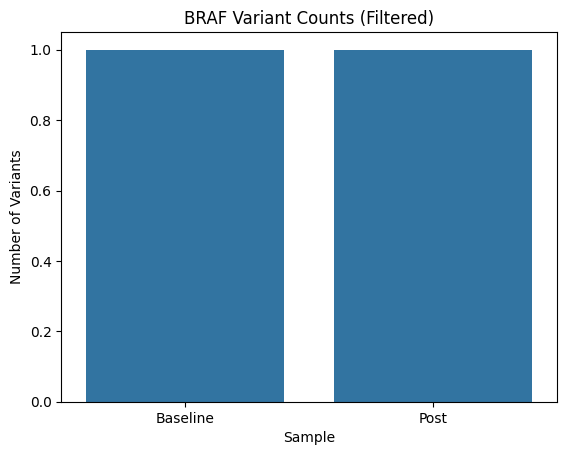

In [ ]:
##Variant Count Plot
counts = pd.DataFrame({
    "Sample": ["Baseline", "Post"],
    "Variant_Count": [len(baseline), len(post)]
})

sns.barplot(data=counts, x="Sample", y="Variant_Count")
plt.title("BRAF Variant Counts (Filtered)")
plt.ylabel("Number of Variants")
plt.show()


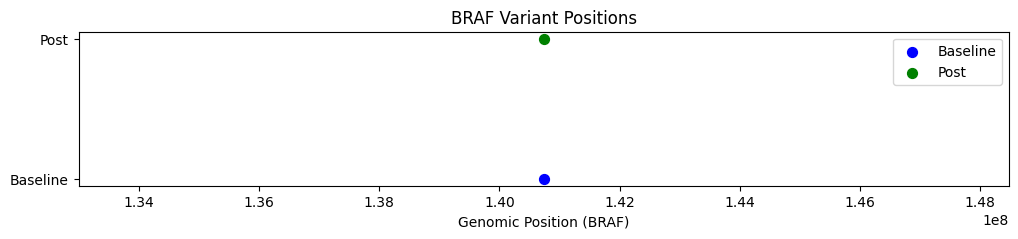

In [ ]:
##Variant Positions Plot
plt.figure(figsize=(12,2))

plt.scatter(baseline["POS"], [1]*len(baseline), color="blue", label="Baseline", s=50)
plt.scatter(post["POS"], [1.2]*len(post), color="green", label="Post", s=50)

plt.yticks([1,1.2], ["Baseline","Post"])
plt.xlabel("Genomic Position (BRAF)")
plt.title("BRAF Variant Positions")
plt.legend()
plt.show()


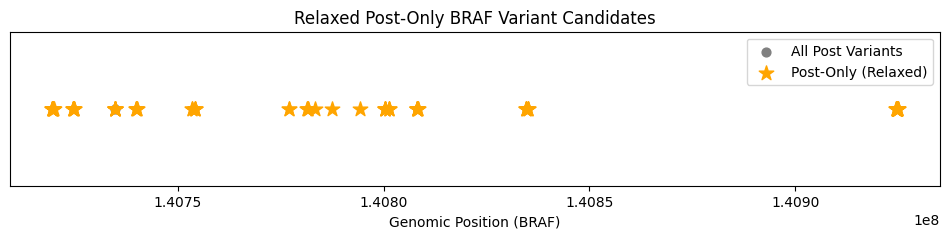

In [ ]:
##post-only variants
plt.figure(figsize=(12,2))

plt.scatter(post["POS"], [1]*len(post), color="gray", label="All Post Variants", s=40)
plt.scatter(post_only_relaxed["POS"], [1]*len(post_only_relaxed),
            color="orange", s=120, marker="*", label="Post-Only (Relaxed)")

plt.xlabel("Genomic Position (BRAF)")
plt.title("Relaxed Post-Only BRAF Variant Candidates")
plt.yticks([])
plt.legend()
plt.show()


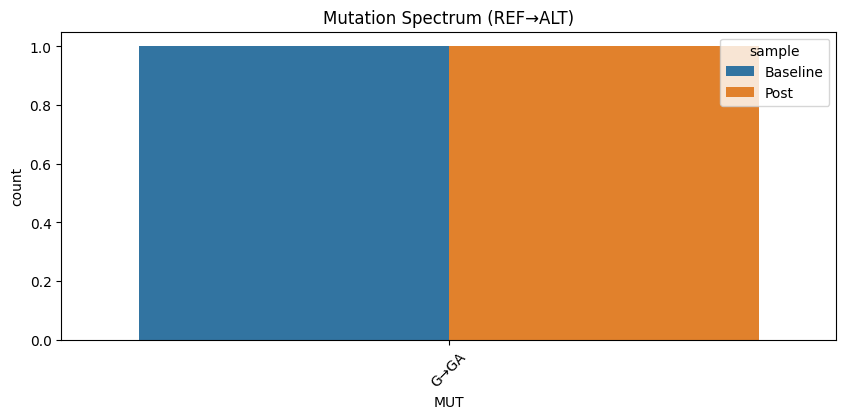

In [ ]:
## Mutation Spectrum Plot (REF to ALT)
baseline["MUT"] = baseline["REF"] + "→" + baseline["ALT"]
post["MUT"] = post["REF"] + "→" + post["ALT"]

merged = pd.concat([
    baseline.assign(sample="Baseline"),
    post.assign(sample="Post")
])

plt.figure(figsize=(10,4))
sns.countplot(data=merged, x="MUT", hue="sample")
plt.xticks(rotation=45)
plt.title("Mutation Spectrum (REF→ALT)")
plt.show()
